# Looking at SHAP values for an Additive model : sklearn's EBM (Explainable Boosting Machine) with OHE

In [1]:
import pandas
import sklearn
import interpret
import matplotlib
from sklearn import model_selection, linear_model, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from interpret import glassbox
from interpret.glassbox import ExplainableBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rxns_df_x = pandas.read_csv("godineau2023_reactions_OHE.csv")
rxns_x = rxns_df_x.to_numpy().copy()
rxns_x = np.delete(rxns_x, 0, 1)
rxns_df_x = rxns_df_x.drop("Unnamed: 0", axis=1)
rxns_df_x

,Cu(OAc)2,Cu2O,CuBr,CuCl,CuI,L1,L10,L11,L12,L2,...,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,EI,TS,UCB
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
260,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
261,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
262,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
rxns_df_y = pandas.read_csv("godineau2023_yields_OHE.csv")
rxns_y = rxns_df_y.to_numpy().copy()
rxns_y = np.delete(rxns_y, 0, axis=1)
rxns_df_y = rxns_df_y[["Yield of 3aa"]]
rxns_df_y

,Yield of 3aa
0,0.00
1,0.00
2,0.00
3,20.63
4,0.00
...,...
259,3.73
260,1.18
261,0.00
262,0.45


In [4]:
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [5]:
model = ExplainableBoostingRegressor(interactions=0)
model.fit(x_train, y_train)

ExplainableBoostingRegressor(interactions=0)

In [6]:
#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.6500811144482415
Validation RMSE:12.093912447852297
Validation MAE:10.008049641793448
Test Set Accuracy with r2 : 0.5858015216156429
Test RMSE:13.861541367283632
Test MAE:10.69409950529525


Accuracy is higher than with non-OHE values

In [7]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [8]:
explainer = shap.Explainer(model.predict, x_train)
shap_values = explainer(x_val)

Permutation explainer: 41it [00:22,  1.75it/s]                        


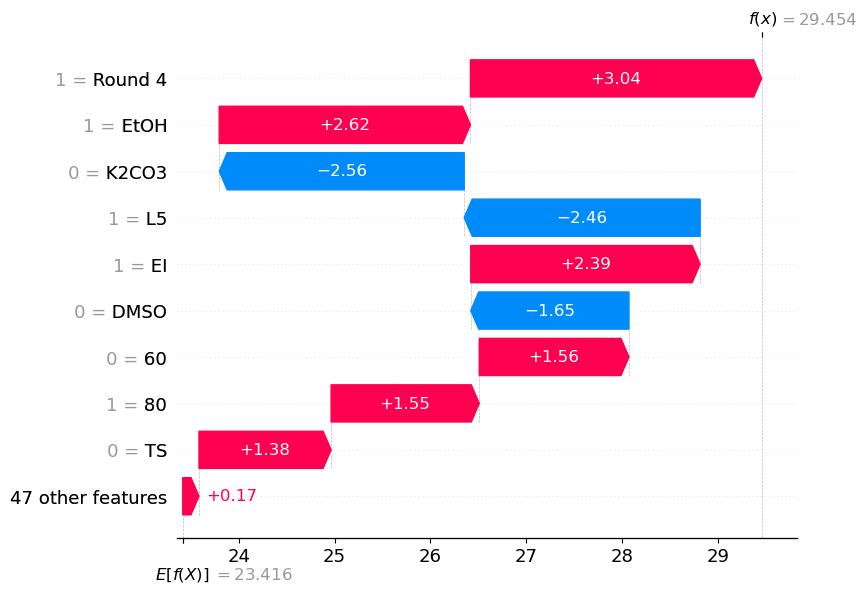

In [9]:
shap.plots.waterfall(shap_values[0], max_display=10)

Observations that fit with our expectations:
- Using EtOH (solvant) tends to make the yield higher
- Not using K2CO3 (base) tends to make the yield lower
- Using L5 tends to make the yield lower
- Using EI as acquisition type tends to make the yield higher, while TS tends to make it lower
- Not using DMSO (solvant) tends to make the yield lower
- Using 80°C instead of 60°C makes the yield higher

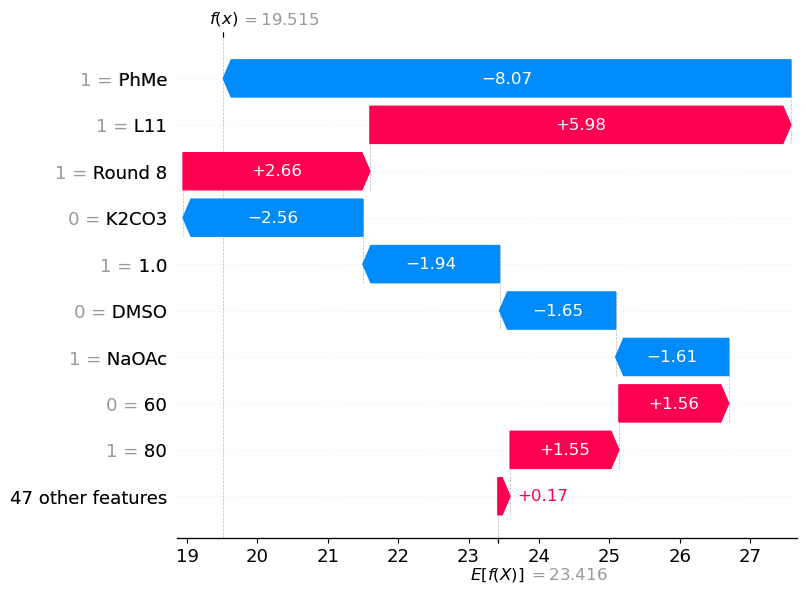

In [10]:
shap.plots.waterfall(shap_values[1], max_display=10)

Other extras:
- Using PhMe (solvant) tends to make the yield lower
- Using NaOAc (base) tends to make the yield lower
- Using L11 tends to make the yield higher

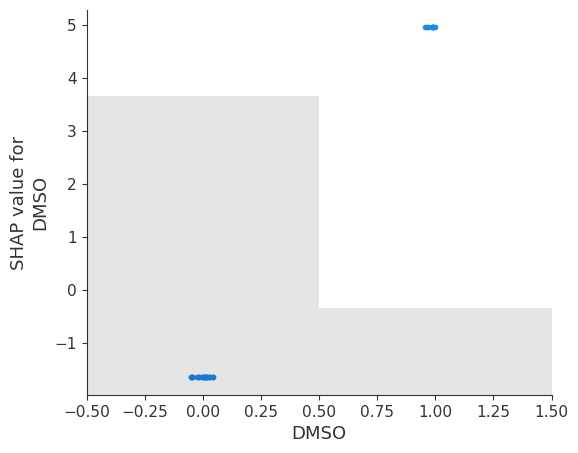

In [12]:
shap.plots.scatter(shap_values[:,"DMSO"])

Using DMSO is better than another solvant

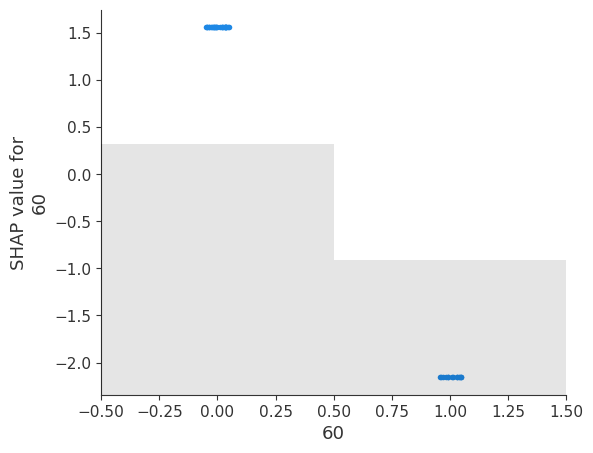

In [13]:
shap.plots.scatter(shap_values[:,"60"])

At 60°C, the yield is lower !

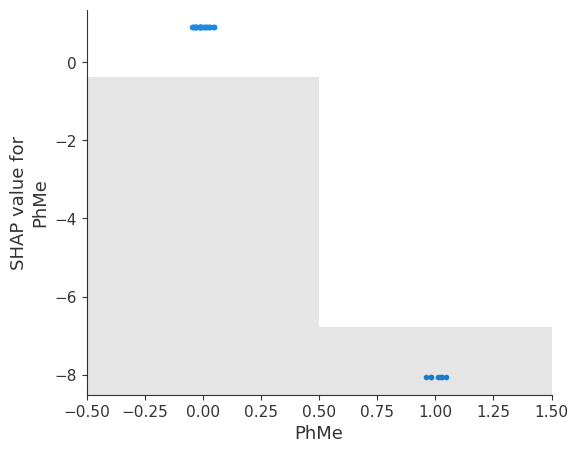

In [18]:
shap.plots.scatter(shap_values[:,"PhMe"])

Not only does the presence of PhMe tend to lower the yield, there are more points with PhMe = 0 than the opposite.

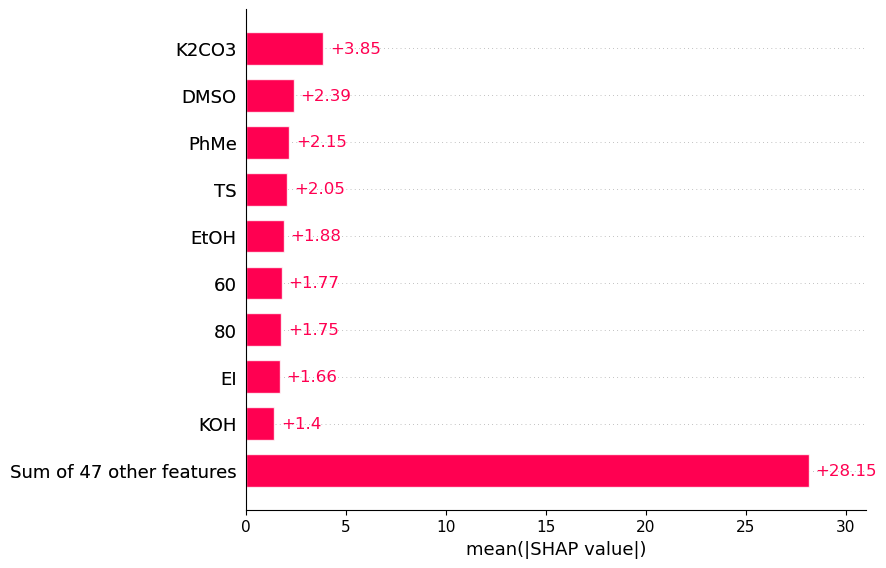

In [14]:
shap.plots.bar(shap_values)

Seeing K2CO3 and DMSO so high up is good, because they are part of the combination leading to the highest yield. 

Note these are overall contributions : in the data, PhMe tends to be used very little meaning its value is often 0, leading to better results than if it were 1. As such its mean SHAP value is positive !

Strange to see 60 and 80 swapped, though. Since this model does not consider interaction between parameters, it's possible it sees the value attributed to 60 as more important than 80 despite them being opposite sides of the same coin.

In [15]:
shap_values_test = explainer(x_test)

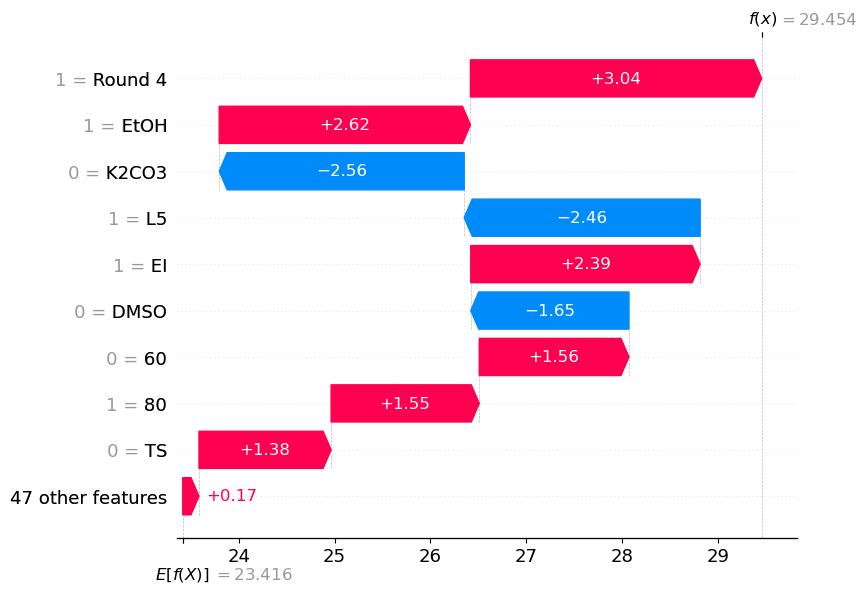

In [16]:
shap.plots.waterfall(shap_values[0], max_display=10)

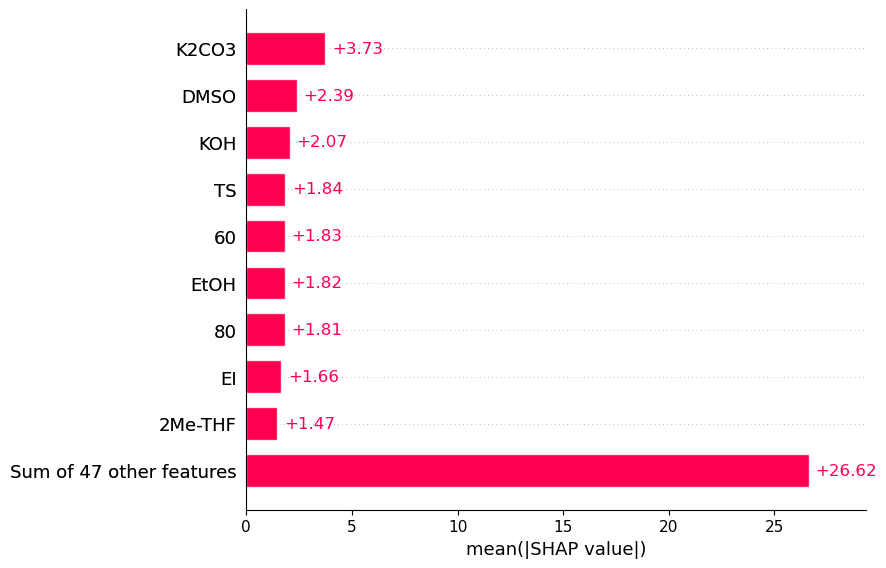

In [17]:
shap.plots.bar(shap_values_test)

This is very similar to the values from the validation set.

An extra : KOH is utilized very little in further rounds which could explain why its mean SHAP gets bigger in the test section.